In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [2]:
# Set your data directory
data_dir = r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset'

# Set image size and batch size
img_size = (224, 224)
batch_size = 32

# Function to load and preprocess data
def load_and_preprocess_data(subdir_name):
    images = []
    labels = []
    class_counts = {}
    
    class_folders = os.listdir(os.path.join(data_dir, subdir_name))
    num_classes = len(class_folders)

    for class_index, class_folder in enumerate(class_folders):
        class_path = os.path.join(data_dir, subdir_name, class_folder)
        num_samples = len(os.listdir(class_path))
        class_counts[class_folder] = num_samples

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            img = load_img(image_path, target_size=img_size)
            img_array = img_to_array(img)
            img_array /= 255.0
            images.append(img_array)
            labels.append(class_index)
    
    images = np.array(images)
    labels = to_categorical(labels, num_classes=num_classes)

    print("Class Representation:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} samples")

    return images, labels, num_classes

In [3]:
# Load and preprocess training data
images, labels, num_classes = load_and_preprocess_data('train')
train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

Class Representation:
Audi: 814 samples
Hyundai Creta: 271 samples
Mahindra Scorpio: 316 samples
Rolls Royce: 311 samples
Swift: 424 samples
Tata Safari: 441 samples
Toyota Innova: 775 samples


Epoch 1/10
84/84 [==============================] - 16s 82ms/step - loss: 2.7561 - accuracy: 0.1940 - val_loss: 1.8903 - val_accuracy: 0.2757
Epoch 2/10
84/84 [==============================] - 5s 63ms/step - loss: 2.4486 - accuracy: 0.2003 - val_loss: 1.8570 - val_accuracy: 0.2757
Epoch 3/10
84/84 [==============================] - 5s 62ms/step - loss: 2.2852 - accuracy: 0.1996 - val_loss: 1.9023 - val_accuracy: 0.2727
Epoch 4/10
84/84 [==============================] - 5s 62ms/step - loss: 2.1970 - accuracy: 0.2044 - val_loss: 1.8954 - val_accuracy: 0.3040
Epoch 5/10
84/84 [==============================] - 5s 63ms/step - loss: 2.0674 - accuracy: 0.2040 - val_loss: 1.9040 - val_accuracy: 0.2712
Epoch 6/10
84/84 [==============================] - 5s 63ms/step - loss: 2.0093 - accuracy: 0.2216 - val_loss: 1.8995 - val_accuracy: 0.2176
Epoch 7/10
84/84 [==============================] - 5s 63ms/step - loss: 1.9489 - accuracy: 0.2451 - val_loss: 1.9183 - val_accuracy: 0.2876
Epoch 8/10
8

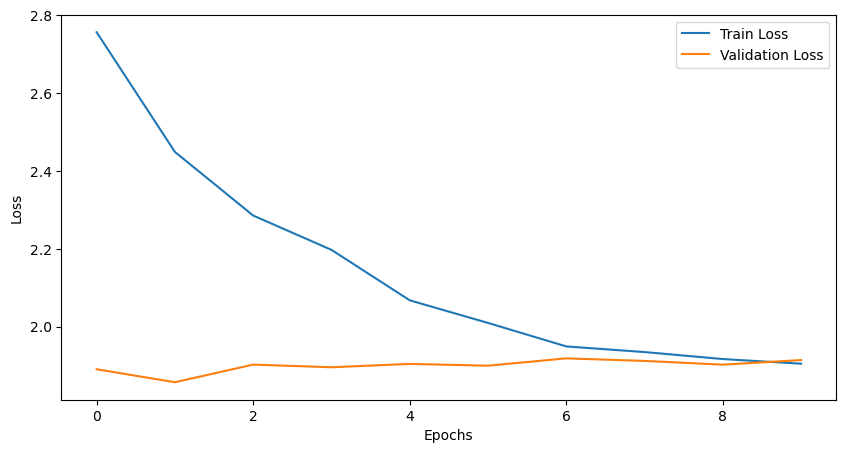

In [4]:
# Load EfficientNetB0 model with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers from EfficientNetB0 model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_images,
    train_labels,
    validation_data=(valid_images, valid_labels),
    batch_size=batch_size,
    epochs=10,
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
# Load the test data
test_images, test_labels, num_classes = load_and_preprocess_data('test')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the test data
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Calculate the confusion matrix
arr = confusion_matrix(true_classes, test_predictions_classes)

# Print the classification report
class_names = [str(i) for i in range(num_classes)]  # Use numeric class labels for the test dataset
classification_rep = classification_report(true_classes, test_predictions_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)


Class Representation:
Audi: 199 samples
Hyundai Creta: 67 samples
Mahindra Scorpio: 75 samples
Rolls Royce: 74 samples
Swift: 102 samples
Tata Safari: 106 samples
Toyota Innova: 190 samples
26/26 [==============================] - 1s 49ms/step - loss: 1.9133 - accuracy: 0.3038
Test Loss: 1.9133285284042358
Test Accuracy: 0.30381304025650024
26/26 [==============================] - 1s 46ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.49      0.43       199
           1       0.00      0.00      0.00        67
           2       0.50      0.01      0.03        75
           3       0.00      0.00      0.00        74
           4       0.00      0.00      0.00       102
           5       0.00      0.00      0.00       106
           6       0.27      0.78      0.40       190

    accuracy                           0.30       813
   macro avg       0.16      0.18      0.12       813
weighted avg       0.20      0.30    

C:\Users\haris\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haris\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haris\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

<AxesSubplot:>

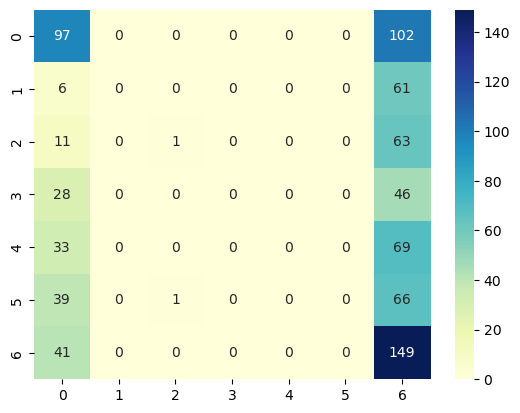

In [10]:
import seaborn as sn
df_cm = pd.DataFrame(arr, range(7), range(7))
sn.heatmap(df_cm, annot=True,fmt="d", cmap="YlGnBu") 

In [7]:
# # Create a DataFrame from the classification report
# classification_dict = classification_report(true_classes, test_predictions_classes, target_names=class_names, output_dict=True)
# classification_df = pd.DataFrame(classification_dict).transpose()

# # Save the DataFrame as an Excel file
# excel_path = os.path.join(r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset', 'classification_report.xlsx')
# classification_df.to_excel(excel_path, index=True)

# print(f"Classification report saved as Excel to {excel_path}")

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      